In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pymeos import *
import contextily as ctx

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

pymeos_initialize()

/tmp/ipykernel_10771/1395957396.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ais = pd.read_csv('./data/aisdk-full.csv')

ais.head()

,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,19/10/2023 00:00:00,Class A,219029699,57.137907,9.127860,Under way using engine,0.0,0.0,340.2,6.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
1,19/10/2023 00:00:00,Class A,219005827,56.803713,9.020183,Engaged in fishing,NaN,0.0,NaN,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
2,19/10/2023 00:00:00,Class A,219006283,56.764315,8.863167,Unknown value,NaN,0.0,190.3,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
3,19/10/2023 00:00:00,Class A,220466000,56.970548,9.257460,Under way using engine,NaN,0.1,134.5,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
4,19/10/2023 00:00:00,Class A,210731000,54.220680,11.386588,Under way using engine,0.0,7.5,242.0,240.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN


In [4]:
print(ais["Type of mobile"].unique())

def is_valid_mmsi(mmsi):
    try:
        mmsi_str = str(int(mmsi))  # Ensure MMSI is convertible to integer and back to string to remove leading zeros
        first_digit = int(mmsi_str[0])
        if first_digit in range(2, 7):
            return True
        else:
            return False
    except ValueError:
        # In case of conversion error (e.g., NaN, empty string, etc.)
        return False

['Class A' 'Base Station' 'Class B' 'AtoN' 'SAR Airborne']


In [5]:
filtered_ais = ais.copy()
filtered_ais = filtered_ais[
    (filtered_ais['Type of mobile'].isin(['Class A'])) &
    (filtered_ais['MMSI'].apply(is_valid_mmsi)) &
    (filtered_ais['Latitude'].notna()) &
    (filtered_ais['Longitude'].notna()) &
    (filtered_ais['SOG'].notna()) &
    (filtered_ais['SOG'] >= 0) & (filtered_ais['SOG'] <= 102)
]

# Convert the 'timestamp' column to datetime objects
filtered_ais['# Timestamp'] = pd.to_datetime(filtered_ais['# Timestamp'], format='%d/%m/%Y %H:%M:%S')

# If you need to format it as a string in a specific format, e.g., ISO format
filtered_ais['# Timestamp'] = filtered_ais['# Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

filtered_ais.rename(columns={'# Timestamp': 't', 'MMSI': 'mmsi', 'Latitude': 'latitude', 'Longitude': 'longitude', 'SOG': 'sog', 'COG': 'cog'}, inplace=True)
filtered_ais.head()

,t,Type of mobile,mmsi,latitude,longitude,Navigational status,ROT,sog,cog,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,2023-10-19 00:00:00,Class A,219029699,57.137907,9.127860,Under way using engine,0.0,0.0,340.2,6.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
1,2023-10-19 00:00:00,Class A,219005827,56.803713,9.020183,Engaged in fishing,NaN,0.0,NaN,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
2,2023-10-19 00:00:00,Class A,219006283,56.764315,8.863167,Unknown value,NaN,0.0,190.3,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
3,2023-10-19 00:00:00,Class A,220466000,56.970548,9.257460,Under way using engine,NaN,0.1,134.5,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
4,2023-10-19 00:00:00,Class A,210731000,54.220680,11.386588,Under way using engine,0.0,7.5,242.0,240.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN


In [6]:
filtered_ais.count()

t                                 8596420
Type of mobile                    8596420
mmsi                              8596420
latitude                          8596420
longitude                         8596420
Navigational status               8596420
ROT                               6307227
sog                               8596420
cog                               8163712
Heading                           7547067
IMO                               8596420
Callsign                          8596420
Name                              8501567
Ship type                         8596420
Cargo type                        1568946
Width                             8270947
Length                            8271288
Type of position fixing device    8596420
Draught                           6949779
Destination                       8578731
ETA                               5734215
Data source type                  8596420
A                                 8262464
B                                 

In [ ]:
filtered_ais['point'] = filtered_ais.apply(lambda row: TGeogPointInst(point=(row['latitude'], row['longitude']), timestamp=row['t']),
                         axis=1)
filtered_ais['sog'] = ais.apply(lambda row: TFloatInst(value=row['sog'], timestamp=row['t']), axis=1)
filtered_ais.head()

In [5]:
trajectories = filtered_ais.groupby('mmsi').aggregate(
    {
        'point': TGeogPointSeq.from_instants,
        'sog': TFloatSeq.from_instants
    }
).rename({'point': 'trajectory'}, axis=1)
trajectories['distance'] = trajectories['trajectory'].apply(lambda t: t.length())
trajectories.head()

,trajectory,sog,distance
mmsi,,,
219001559,[POINT(57.592245 9.975512)@2021-01-08 00:00:05...,"[0.1@2021-01-08 00:00:05+01, 0.1@2021-01-08 00...",17765.588739
219027804,[POINT(55.94244 11.866278)@2021-01-08 00:00:01...,"[0@2021-01-08 00:00:01+01, 0@2021-01-08 00:34:...",94963.575026
257136000,[POINT(56.911257 7.122958)@2021-01-08 00:02:57...,"[14@2021-01-08 00:02:57+01, 13.9@2021-01-08 00...",940404.131239
265513270,[POINT(57.059 12.272388)@2021-01-08 00:00:00+0...,"[0@2021-01-08 00:00:00+01, 0@2021-01-08 00:00:...",1629.539165
566948000,[POINT(55.574352 4.617153)@2021-01-08 00:00:04...,"[0.5@2021-01-08 00:00:04+01, 0.5@2021-01-08 00...",28215.190430


In [6]:
pd.concat([filtered_ais.groupby('mmsi')['t'].count().rename('original #points'),
           trajectories['trajectory'].apply(lambda t: t.num_instants()).rename('PyMEOS #points')],
          axis=1)

,original #points,PyMEOS #points
mmsi,,
219001559,48323,36494
219027804,38326,17161
257136000,21770,21120
265513270,21799,7954
566948000,26619,24175


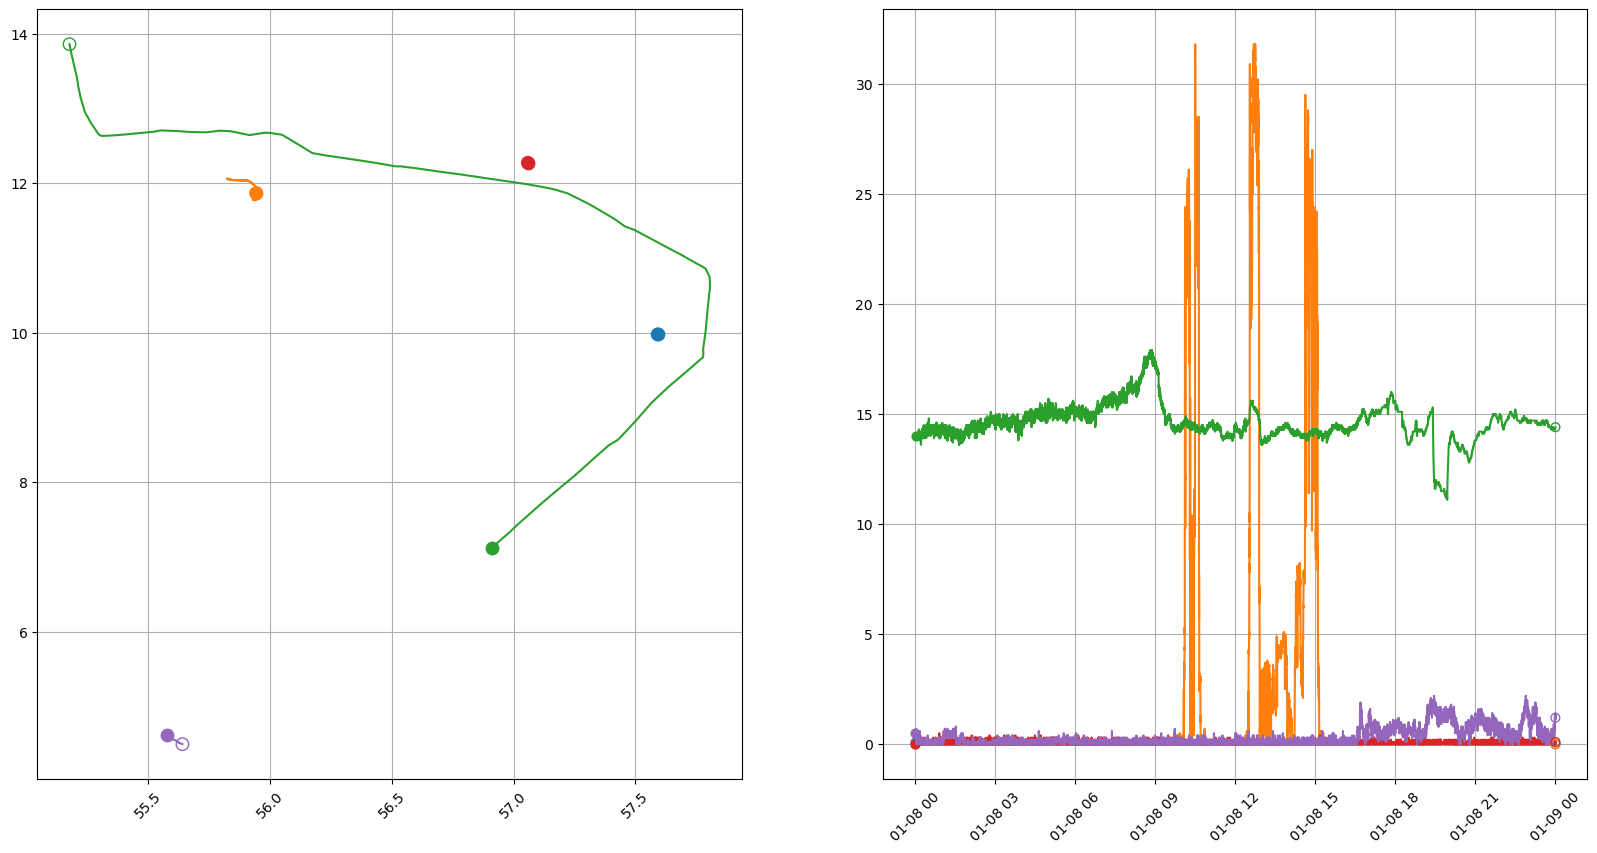

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for _, ship in trajectories.iterrows():
    ship['trajectory'].plot(axes=axes[0])
    ship['sog'].plot(axes=axes[1])
plt.show()

219001559
219027804
257136000
265513270
566948000


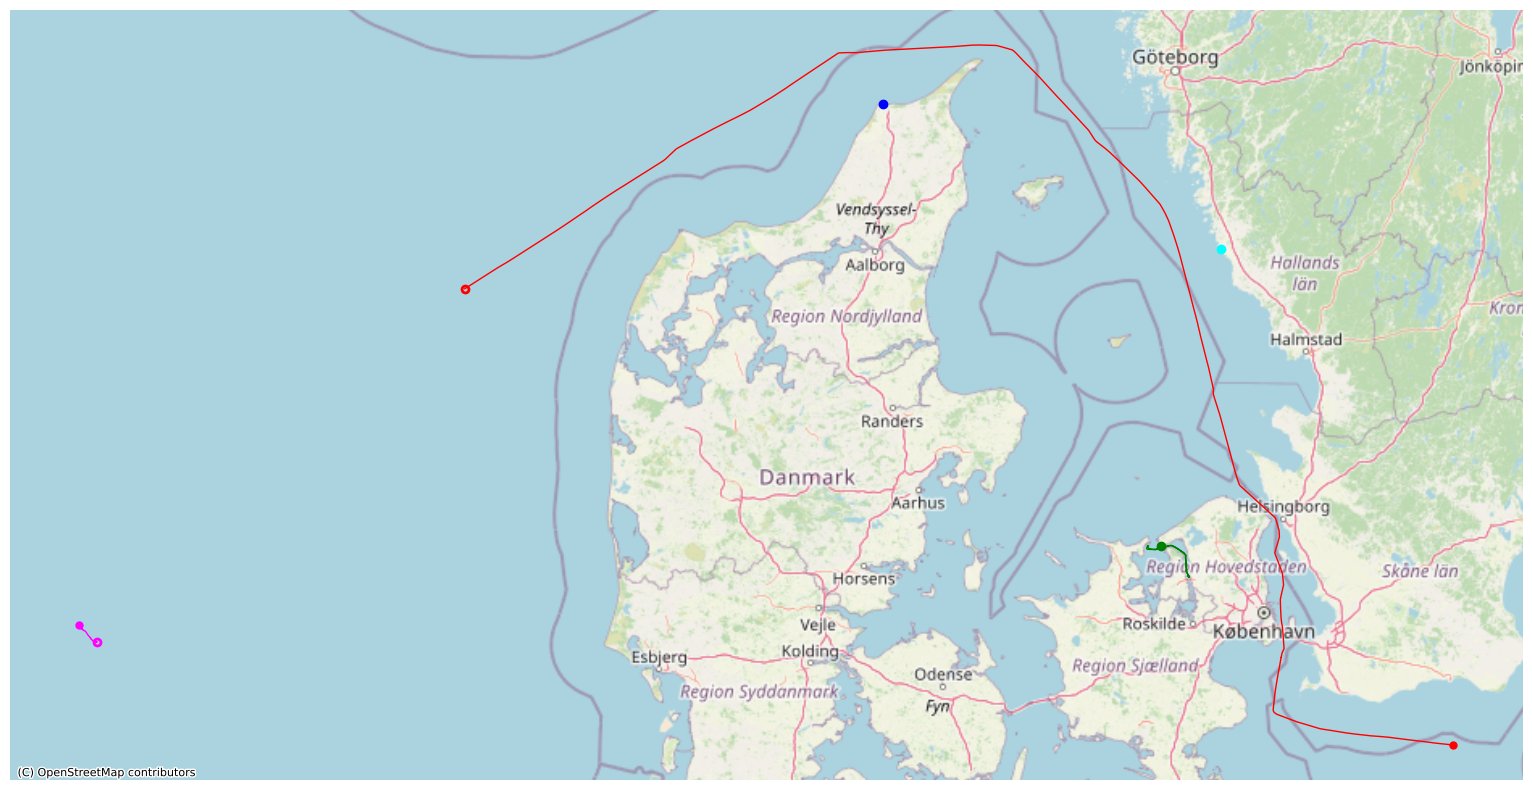

In [65]:
from itertools import cycle
# Define a list of colors to cycle through
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
color_cycle = cycle(colors)
fig, ax = plt.subplots(figsize=(20, 10))

for idx, ship in trajectories.iterrows():
    print(idx)
    points_df = ship['trajectory'].to_dataframe()

    corrected_points = [Point(p.y, p.x) for p in points_df['value']]
    gdf_corrected = gpd.GeoDataFrame(geometry=corrected_points, crs="EPSG:4326")
    gdf_corrected = gdf_corrected.to_crs(epsg=3857)
    
    # Extract x and y coordinates for plotting
    x, y = gdf_corrected.geometry.x, gdf_corrected.geometry.y
    
    # Get the next color from the cycle
    color = next(color_cycle)
    
    # Use Matplotlib's plot function for more precise control over line properties
    ax.plot(x, y, color=color, linewidth=1)  # Adjust linewidth here

    # Plot start and end points
    ax.plot(x.iloc[0], y.iloc[0], marker='o', markersize=5, markerfacecolor='none', markeredgecolor=color, markeredgewidth=2)
    ax.plot(x.iloc[-1], y.iloc[-1], marker='o', markersize=5, color=color)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_corrected.crs)

ax.set_axis_off()
plt.show()

In [12]:
pymeos_finalize()